In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [3]:
%cd gdrive/My\ Drive/nlp/
!ls

/content/gdrive/My Drive/nlp
test.csv  train.csv


In [60]:
import re
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from scipy.sparse import hstack
from wordcloud import WordCloud

In [44]:
df_train = pd.read_csv('train.csv').fillna(' ')
df_test = pd.read_csv('test.csv').fillna(' ')

df_train.keyword = df_train.keyword.str.replace("%20", " ")
df_test.keyword = df_test.keyword.str.replace("%20", " ")


# EDA

## Target and not target records count

0    4342
1    3271
Name: target, dtype: int64


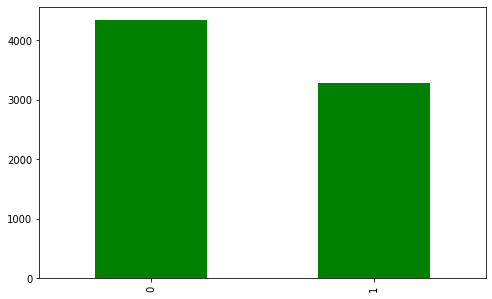

In [33]:
plt.figure(figsize=(8,5))
df_train['target'].value_counts().plot(kind='bar',color='green')
print(df_train['target'].value_counts())

## Keywords statistics

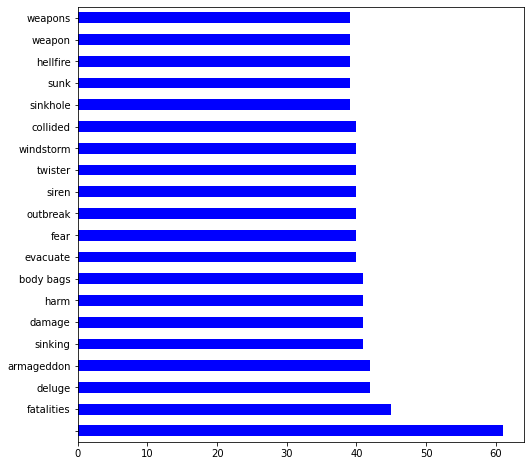

In [34]:
plt.figure(figsize=(8,8))
df_train['keyword'].value_counts()[:20].plot(kind='barh',color='blue')

## Locations statistics

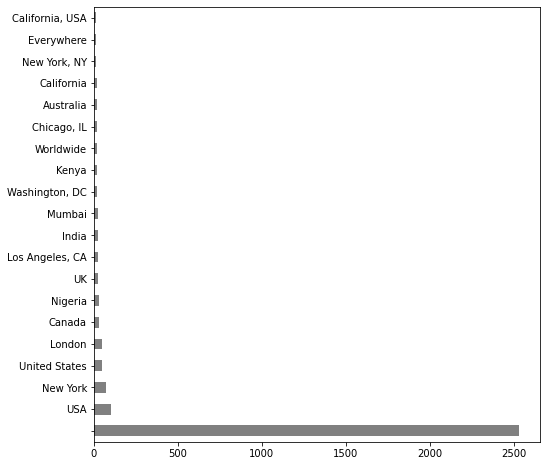

In [35]:
plt.figure(figsize=(8,8))
df_train['location'].value_counts()[:20].plot(kind='barh',color='grey')

## Disaster and Non Disaster tweets length

Text(0.5, 1.0, 'Non Disaster tweets length')

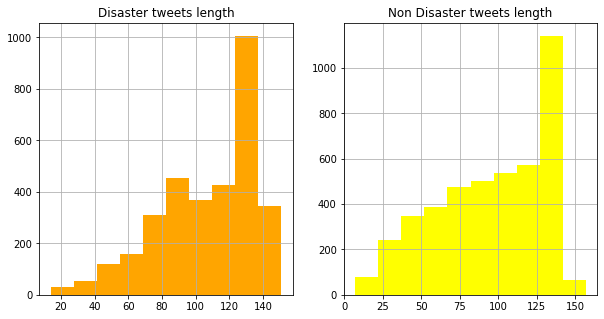

In [36]:
tweet_dis = df_train[df_train['target']==1]
tweet_ndis = df_train[df_train['target']==0]
len_dis = tweet_dis.text.str.len()
len_ndis = tweet_ndis.text.str.len()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(len_dis,color='orange')
plt.grid()
plt.title('Disaster tweets length')
plt.subplot(1,2,2)
plt.hist(len_ndis,color='yellow',)
plt.grid()
plt.title('Non Disaster tweets length')

## Disaster and Non Disaster word length

Text(0.5, 1.0, 'Non Disaster word length')

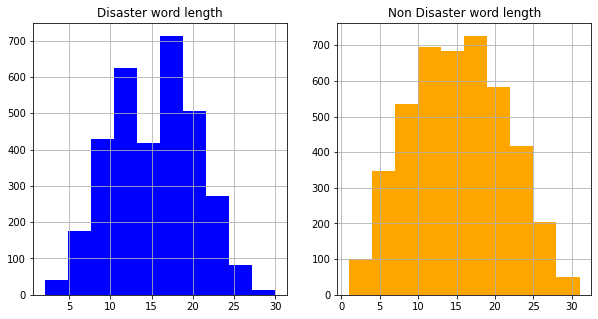

In [37]:
words_dis = df_train[df_train['target']==1]['text'].str.split().map(lambda x:len(x))
words_ndis = df_train[df_train['target']==0]['text'].str.split().map(lambda x:len(x))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(words_dis,color='blue')
plt.grid()
plt.title('Disaster word length')
plt.subplot(1,2,2)
plt.hist(words_ndis,color='orange',)
plt.grid()
plt.title('Non Disaster word length')

# Data preprocessing

In [49]:
df_train.text = df_train.text.str.encode('ascii', 'ignore').str.decode("ascii")
df_test.text = df_test.text.str.encode('ascii', 'ignore').str.decode("ascii")
df_train.text = df_train.text.apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))
df_test.text = df_train.text.apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))

# Cloud of words

## Keywords

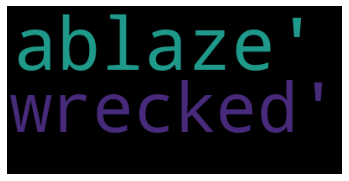

In [67]:
text = df_train.query('keyword!=" "').keyword.values

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Locations

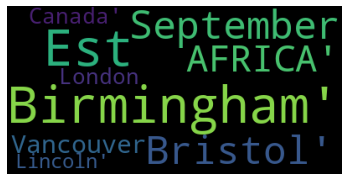

In [68]:
text = df_train.query('location!=" "').location.values

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Text

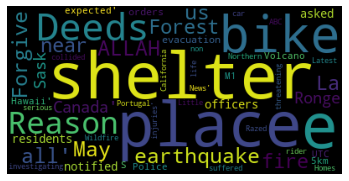

In [69]:
text = df_train.text.values

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# sklearn.CountVectorize

In [23]:
count_vectorizer = feature_extraction.text.CountVectorizer()

train_vectors = count_vectorizer.fit_transform(df_train["text"])
test_vectors = count_vectorizer.transform(df_test["text"])

In [51]:
print(train_vectors[0].todense().shape)
print(test_vectors[0].todense().shape)

train_vectors_df = pd.DataFrame(train_vectors.todense())
train_vectors_df.head()

(1, 21735)
(1, 21735)


,0,1,2,3,4,5,6,7,8,9,...,21725,21726,21727,21728,21729,21730,21731,21732,21733,21734
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
test_vectors_df = pd.DataFrame(test_vectors.todense())
test_vectors_df.head()

,0,1,2,3,4,5,6,7,8,9,...,21725,21726,21727,21728,21729,21730,21731,21732,21733,21734
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# TF-IDF

In [9]:
train_text = df_train['text']
test_text = df_test['text']
summary_text = pd.concat([train_text, test_text])

In [10]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(summary_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

In [11]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(2, 6),
    max_features=50000)
char_vectorizer.fit(summary_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

In [12]:
train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

In [13]:
train_features.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
train_oof = np.zeros(df_train.shape[0],)
kf = KFold(n_splits=5, random_state=137, shuffle=True)
test_preds = 0

for jj, (train_index, val_index) in enumerate(kf.split(train_features)):
        print("Fitting fold", jj+1)
        train_x = train_features.toarray()[train_index]
        val_x = train_features.toarray()[val_index]
        train_target = df_train['target'].values[train_index]
        classifier = LogisticRegression(solver='sag')
        classifier.fit(train_x, train_target)
        train_oof[val_index] = classifier.predict_proba(val_x)[:,1]
        test_preds += classifier.predict_proba(test_features)[:,1]/5
        
print(roc_auc_score(df_train['target'].values, train_oof))

Fitting fold 1
Fitting fold 2


In [ ]:
submission =pd.read_csv('sample_submission.csv')
submission.head()

In [ ]:
submission['target'] = 1*(test_preds > 0.5)
submission.head()